Programa para hacer upsampling de una serie de datos no equidistantes

In [1]:
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib.pyplot as plt

In [2]:
def get_peak_out(ts):
    l_i = []
    i = 0
    for date, val in ts.iteritems():
        if i:
            if ((ts[i] - ts[i-1]) > 30):
                l_i.append(str(date))
        i = i + 1

    for elem in l_i:
        ts = ts.drop(Timestamp(elem))
    return ts

In [3]:
"""
datafile = 'G3922-02_reapriete.csv' # Archivo a Interpolar
datafile = 'G3968-02_reapriete.csv' # Archivo a Interpolar
datafile = 'G3875-03_reapriete.csv' # Archivo a Interpolar
datafile = 'G3921-03_reapriete.csv' # Archivo a Interpolar
datafile = 'G3965-01_reapriete.csv' # Archivo a Interpolar
datafile = 'G3965-02_reapriete.csv' # Archivo a Interpolar
datafile = 'G4016-01_reapriete.csv' # Archivo a Interpolar
datafile = 'G3469-02_reapriete.csv' # Archivo a Interpolar
datafile = 'G3909-01_reapriete.csv' # Archivo a Interpolar
datafile = 'G3485-01_reapriete.csv' # Archivo a Interpolar
"""

"\ndatafile = 'G3922-02_reapriete.csv' # Archivo a Interpolar\ndatafile = 'G3968-02_reapriete.csv' # Archivo a Interpolar\ndatafile = 'G3875-03_reapriete.csv' # Archivo a Interpolar\ndatafile = 'G3921-03_reapriete.csv' # Archivo a Interpolar\ndatafile = 'G3965-01_reapriete.csv' # Archivo a Interpolar\ndatafile = 'G3965-02_reapriete.csv' # Archivo a Interpolar\ndatafile = 'G4016-01_reapriete.csv' # Archivo a Interpolar\ndatafile = 'G3469-02_reapriete.csv' # Archivo a Interpolar\ndatafile = 'G3909-01_reapriete.csv' # Archivo a Interpolar\ndatafile = 'G3485-01_reapriete.csv' # Archivo a Interpolar\n"

In [4]:
datafile = 'G3909-01_reapriete.csv' # Archivo a Interpolar
directory = './RP/'
df = pd.read_csv(directory + datafile)                 # Directorio
#columnas = ['created', 'tp']
#data_name = "termopar"
#columnas = ['created', 'pre']
#data_name = "presion"
#columnas = ['created', 'hum']
#data_name = "humedad"
columnas = ['created', 'amb']
data_name = "ambiental"

filename = datafile.split(".")
datafile = "{}_{}.{}".format(filename[0], data_name, filename[1])

#filtra columnas innecesarias
df = df.filter(items=columnas)
#filtra 0's del archivo
df = df.loc[df[columnas[1]] > 0]
df.shape

(43703, 2)

df1 = df[:len(df)//2]
df2 = df[len(df)//2:]
df = df2

df = df2
indice = np.argmax(df["data"])
print(df["data"][indice])
del df["data"][indice]
indice = np.argmax(df["data"])
print(df["data"][indice])

In [5]:
df.columns = ['timestamps','values']
timestamps = pd.to_datetime(df['timestamps'].values)
values = df['values'].values

#------ Tambien puedes interpolar valores en especifico------#
#values = [722.46,5]
#timestamps = pd.to_datetime(['4/22/2018 4:00:02','4/22/2018 14:00:00'])

In [6]:
ts = pd.Series(values, index=timestamps)

In [7]:
ts = ts[~ts.index.duplicated()]
ts[ts==-1] = np.nan

In [8]:
#print(len(ts))
#while((len(ts) - len(get_peak_out(ts))) > 30):
#    ts = get_peak_out(ts)
#    print(len(ts))

In [9]:
newFreq=ts.resample('2S').asfreq()

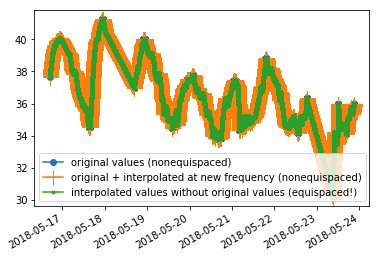

In [10]:
new = (ts.reindex(ts.index | newFreq.index)
           .interpolate(method='time')
           .loc[newFreq.index])

ts.plot(marker='o')
new.plot(marker='+',markersize=15)

new[newFreq.index].plot(marker='.')

lines, labels = plt.gca().get_legend_handles_labels()
labels = ['original values (nonequispaced)', 'original + interpolated at new frequency (nonequispaced)', 'interpolated values without original values (equispaced!)']
plt.legend(lines, labels, loc='best')
plt.show()

In [11]:
# Se guarda el nuevo archivo
interpol = 'interpolated_2s_' + datafile
new.to_csv('./RP_outputs/' + interpol)
new.shape

(309898,)

In [12]:
# Smoothing this shit with Dr. P-pillo code
import scipy.signal as signal

In [13]:
data_to_smooth = new[1:]
new = new[1:]
data_to_smooth.shape

(309897,)

In [14]:
data_cp = new.copy()

In [15]:
# apply low-pass filter
smooth_plots = []
# First, design the Buterworth filter
order  = 2   # Filter order
Wn = 0.1 # Cutoff frequency
B, A = signal.butter(order, Wn, output='ba')
smooth_plots = signal.filtfilt(B, A, data_to_smooth)
#smooth_plots = a_valores.apply(lambda row: signal.filtfilt(B, A, row))

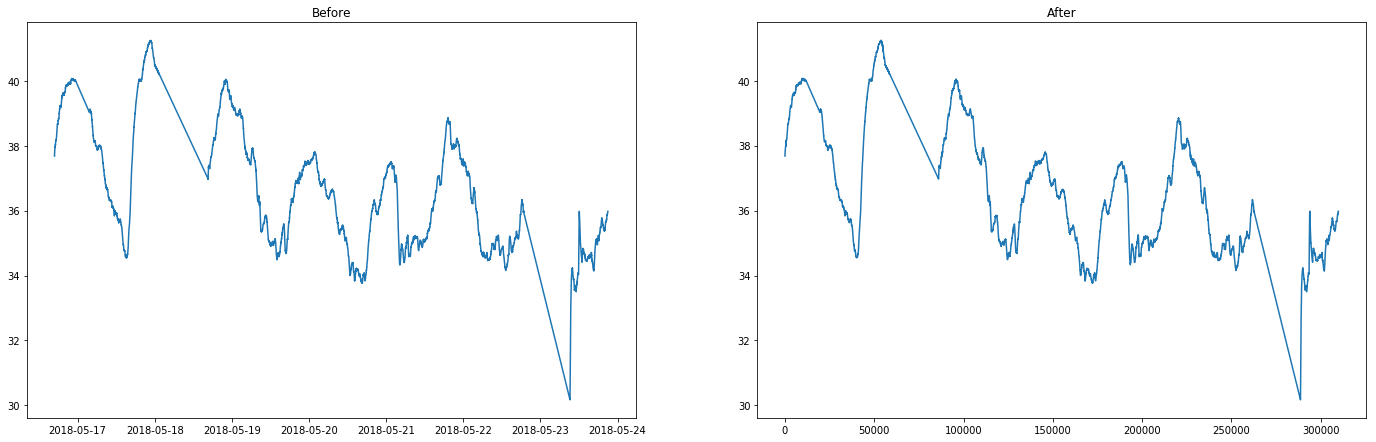

In [16]:
# plot current state vs result
fig = plt.figure(figsize=(24, 16))

ax1 = fig.add_subplot(221)
ax1.set_title("Before")
ax1.plot(data_to_smooth)

ax2 = fig.add_subplot(222)
ax2.set_title("After")
ax2.plot(smooth_plots)

plt.show()

In [17]:
data_cp[0:] = smooth_plots
if (data_cp == new).all(): #son iguales! D:
    raise "No se hizo bien el smooth"

In [18]:
# Se guarda el nuevo archivo
smooth = 'smoothed_2s_' + datafile
new.to_csv('./RP_outputs/' + smooth)

In [19]:
df = pd.read_csv('./RP_outputs/' + smooth)     # Directorio
df.columns = ['timestamps','values']
timestamps = pd.to_datetime(df['timestamps'].values)
values = df['values'].values
ts = pd.Series(values, index=timestamps)
ts = ts[~ts.index.duplicated()]
ts[ts==-1] = np.nan

In [20]:
newFreq=ts.resample('300S').asfreq()

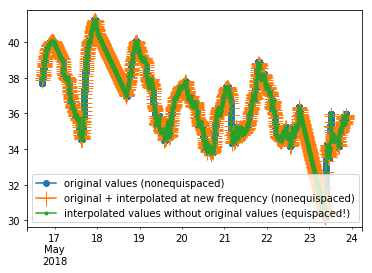

In [21]:
new = (ts.reindex(ts.index | newFreq.index)
           .interpolate(method='time')
           .loc[newFreq.index])

ts.plot(marker='o')
new.plot(marker='+',markersize=15)

new[newFreq.index].plot(marker='.')

lines, labels = plt.gca().get_legend_handles_labels()
labels = ['original values (nonequispaced)', 'original + interpolated at new frequency (nonequispaced)', 'interpolated values without original values (equispaced!)']
plt.legend(lines, labels, loc='best')
plt.show()

In [22]:
# Se guarda el nuevo archivo
last = 'interpolated_5min_' + datafile
new.to_csv('./RP_outputs/' + last)